# Install Transformers Library

In [1]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 13.3 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 40.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config


# specify GPU
device = torch.device("cuda")

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Load Dataset

In [4]:
df = pd.read_excel("/content/gdrive/MyDrive/BERT fine tuning/Dataset/small_dataset1.xlsx")
df.head()

,class,Symptom Severity,Delusion Score,text
0,patient,72,12,I would wake up greet my pet/friend use the ...
1,patient,92,22,"On a average Sunday I wake up, brush my teet..."
2,patient,64,4,Well This white lady moved in my hood an she...
3,control,0,0,sometimes when my family comes around and th...
4,patient,79,10,The thing that makes me the angriest is when...


In [5]:
df.shape

(373, 4)

In [6]:
df['class'] = df['class'].replace(['patient','control'],[0,1])

In [7]:
# check class distribution
df['class'].value_counts(normalize = True)

1    0.509383
0    0.490617
Name: class, dtype: float64

# Split train dataset into train, validation and test sets

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'].astype('str'), df['class'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['class'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [9]:
# Load the GPT tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('/content/gdrive/MyDrive/BERT fine tuning/Models/retrained_gpt/')
# import GPT pretrained model
gpt_config = GPT2Config.from_pretrained('/content/gdrive/MyDrive/BERT fine tuning/Models/retrained_gpt/', num_classes=2, pad_token=tokenizer.eos_token, pad_token_id=tokenizer.eos_token_id)
gpt = GPT2ForSequenceClassification.from_pretrained('/content/gdrive/MyDrive/BERT fine tuning/Models/retrained_gpt/', config=gpt_config)


Some weights of the model checkpoint at /content/gdrive/MyDrive/BERT fine tuning/Models/retrained_gpt/ were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /content/gdrive/MyDrive/BERT fine tuning/Models/retrained_gpt/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
tokenizer.pad_token = tokenizer.eos_token
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [11]:
# output
print(sent_id)

{'input_ids': [[5661, 318, 257, 275, 861, 2746, 11808, 50256, 50256, 50256], [732, 481, 3734, 12, 83, 1726, 257, 275, 861, 2746]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

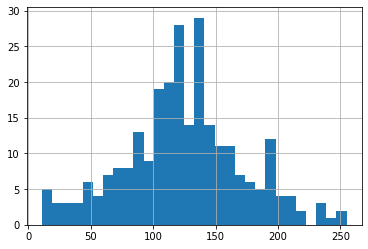

In [12]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [13]:
max_seq_len = 120

In [14]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.float32)

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.float32)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist(), dtype=torch.float32)

# Create DataLoaders

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [17]:
# # freeze all the parameters
# for name, param in gpt.named_parameters():
#   param.requires_grad = False

# freeze all the parameters
for name, param in gpt.named_parameters():
    if name in ['transformer.ln_f.weight', 'transformer.ln_f.bias', 'score.weight']:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define Model Architecture

In [18]:
class GPT_Arch(nn.Module):

    def __init__(self, gpt):
      
      super(GPT_Arch, self).__init__()

      self.gpt = gpt

      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      x = self.gpt(input_ids=sent_id, attention_mask=mask)

      return self.softmax(x[0])

In [19]:
# pass the pre-trained BERT to our define architecture
model = GPT_Arch(gpt)

# push the model to GPU
model = model.to(device)

In [20]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-3)

# Find Class Weights

In [21]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.01953125 0.98120301]


In [22]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 40

# Fine-Tune BERT

In [23]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels.long())

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [24]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels.long())

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 40

Evaluating...

Training Loss: 0.907
Validation Loss: 1.025

 Epoch 2 / 40

Evaluating...

Training Loss: 0.486
Validation Loss: 0.898

 Epoch 3 / 40

Evaluating...

Training Loss: 0.460
Validation Loss: 0.845

 Epoch 4 / 40

Evaluating...

Training Loss: 0.317
Validation Loss: 0.877

 Epoch 5 / 40

Evaluating...

Training Loss: 0.316
Validation Loss: 0.936

 Epoch 6 / 40

Evaluating...

Training Loss: 0.306
Validation Loss: 0.952

 Epoch 7 / 40

Evaluating...

Training Loss: 0.224
Validation Loss: 0.995

 Epoch 8 / 40

Evaluating...

Training Loss: 0.223
Validation Loss: 1.034

 Epoch 9 / 40

Evaluating...

Training Loss: 0.245
Validation Loss: 0.996

 Epoch 10 / 40

Evaluating...

Training Loss: 0.223
Validation Loss: 0.923

 Epoch 11 / 40

Evaluating...

Training Loss: 0.140
Validation Loss: 0.904

 Epoch 12 / 40

Evaluating...

Training Loss: 0.148
Validation Loss: 0.997

 Epoch 13 / 40

Evaluating...

Training Loss: 0.138
Validation Loss: 0.905

 Epoch 14 / 40

Eval

# Load Saved Model

In [26]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [27]:
# get predictions for test data
model.eval()
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [28]:
preds

array([[-1.4526399 , -0.26651034],
       [-0.61571884, -0.7770776 ],
       [-2.9579408 , -0.0533225 ],
       [-0.69000155, -0.6963028 ],
       [-0.11537497, -2.2167008 ],
       [-0.12101754, -2.1717188 ],
       [-0.14796759, -1.983834  ],
       [-2.2553358 , -0.11075098],
       [-0.22650513, -1.5961033 ],
       [-0.07924497, -2.574573  ],
       [-0.2690992 , -1.4442096 ],
       [-1.3344712 , -0.3055709 ],
       [-2.3051398 , -0.10507707],
       [-0.64091927, -0.74825394],
       [-1.0377067 , -0.4373679 ],
       [-0.7386198 , -0.6496527 ],
       [-1.5402508 , -0.24121505],
       [-0.69105643, -0.6952422 ],
       [-0.03293975, -3.4295008 ],
       [-1.0782294 , -0.41581452],
       [-1.9073732 , -0.16072041],
       [-0.6932763 , -0.69301814],
       [-0.4091047 , -1.0913727 ],
       [-1.5733162 , -0.23238163],
       [-0.31562608, -1.3068627 ],
       [-2.2218032 , -0.11475275],
       [-0.02778956, -3.5969567 ],
       [-0.5299885 , -0.8882177 ],
       [-2.7760077 ,

In [29]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68        28
         1.0       0.68      0.68      0.68        28

    accuracy                           0.68        56
   macro avg       0.68      0.68      0.68        56
weighted avg       0.68      0.68      0.68        56



In [30]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0.0,19,9
1.0,9,19
